# Determine Whether the DIA Data is Overlapping

In [52]:
import os
from pathlib import Path
import dataclasses
import re
import statistics
import dotenv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pyopenms import MSExperiment, MzMLFile

%matplotlib inline

In [10]:
REPO_DIR = Path(os.getcwd()).resolve().parent.parent.parent
dotenv.load_dotenv(REPO_DIR / ".env")
DATA_DIR = Path(os.environ['DATA_DIR'])

In [11]:
exp = MSExperiment()
MzMLFile().load(str(DATA_DIR/"mzML/LFQ_TTOF5600_SWATH_Ecoli_01-LFQ_TT5600_SWATH_Micro_120_Min_Ecoli_01.mzML"), exp)

In [12]:
exp

MSExperiment(num_spectra=151946, num_chromatograms=8, ms_levels=[1, 2], rt_range=[0.00, 8397.36])

In [ ]:
ms2_scans = {
    'native_id': [],
    'rt': [],
    'precursor_mz': [],
    'precursor_mz_lower_offset': [],
    'precursor_mz_upper_offset': []
}
for spectrum in exp:
    ms_level = spectrum.getMSLevel()
    native_id = spectrum.getNativeID()
    if ms_level == 2:
        rt = spectrum.getRT()
        precursors = spectrum.getPrecursors()
        if len(precursors) > 0:
            precursor = precursors[0]
            precursor_mz = precursor.getMZ()
            precursor_mz_lower_offset = precursor.getIsolationWindowLowerOffset()
            precursor_mz_upper_offset = precursor.getIsolationWindowUpperOffset()
            ms2_scans['native_id'].append(native_id)
            ms2_scans['rt'].append(rt)
            ms2_scans['precursor_mz'].append(precursor_mz)
            ms2_scans['precursor_mz_lower_offset'].append(precursor_mz_lower_offset)
            ms2_scans['precursor_mz_upper_offset'].append(precursor_mz_upper_offset)

In [36]:
df_ms2_scan = pd.DataFrame(ms2_scans)

In [37]:
df_ms2_scan

,native_id,rt,precursor_mz,precursor_mz_lower_offset,precursor_mz_upper_offset
0,sample=1 period=1 cycle=1 experiment=2,0.226,403.85,4.35,4.35
1,sample=1 period=1 cycle=1 experiment=3,0.278,411.50,4.30,4.30
2,sample=1 period=1 cycle=1 experiment=4,0.330,418.75,3.95,3.95
3,sample=1 period=1 cycle=1 experiment=5,0.382,425.70,4.00,4.00
4,sample=1 period=1 cycle=1 experiment=6,0.433,433.00,4.30,4.30
...,...,...,...,...,...
149607,sample=1 period=1 cycle=2374 experiment=61,8397.147,956.35,15.25,15.25
149608,sample=1 period=1 cycle=2374 experiment=62,8397.199,988.30,17.70,17.70
149609,sample=1 period=1 cycle=2374 experiment=63,8397.251,1029.00,24.00,24.00
149610,sample=1 period=1 cycle=2374 experiment=64,8397.303,1081.30,29.30,29.30


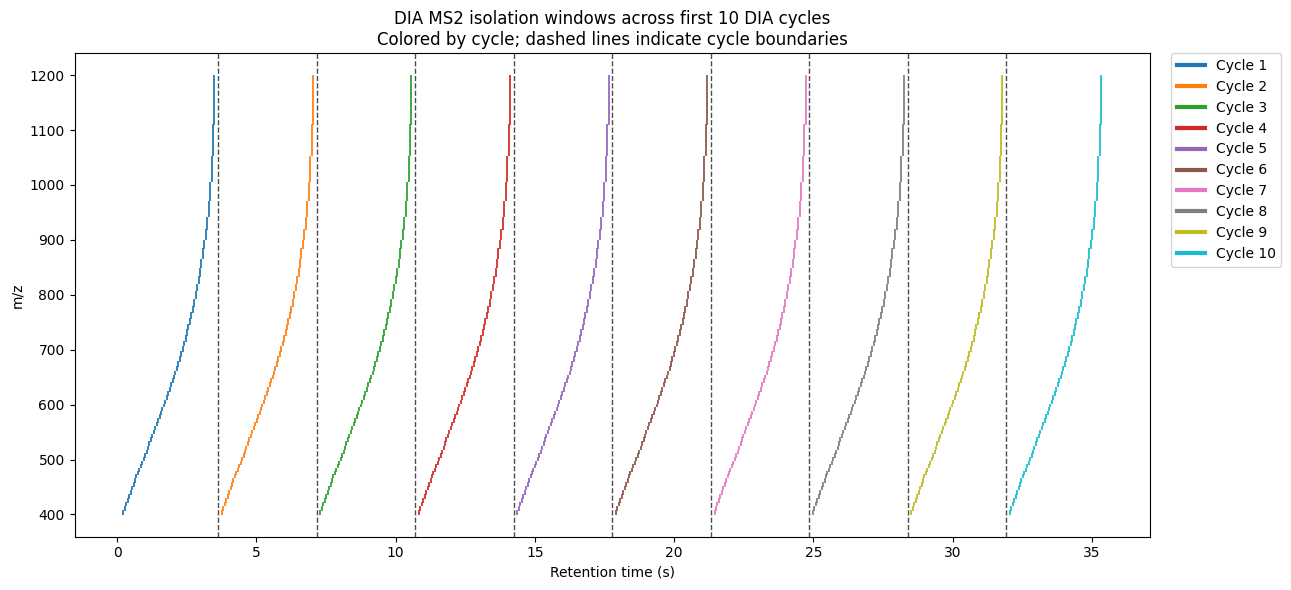

In [44]:
df = df_ms2_scan.copy()
df["mz_low"] = df["precursor_mz"] - df["precursor_mz_lower_offset"]
df["mz_high"] = df["precursor_mz"] + df["precursor_mz_upper_offset"]
df["cycle"] = (
    df["native_id"]
    .str.extract(r"cycle=(\d+)")
    .astype(int)
)

cycles = sorted(df["cycle"].unique())[:10]
df = df[df["cycle"].isin(cycles)].sort_values(["cycle", "rt"])

# compute cycle RT ranges
cycle_rt = df.groupby("cycle")["rt"].agg(["min", "max"]).sort_index()

# boundary between cycle k and k+1
boundaries = []
cycle_list = cycle_rt.index.to_list()
for i in range(len(cycle_list) - 1):
    c0 = cycle_list[i]
    c1 = cycle_list[i + 1]
    boundaries.append((cycle_rt.loc[c0, "max"] + cycle_rt.loc[c1, "min"]) / 2.0)

palette = sns.color_palette(n_colors=len(cycle_list))
cycle_to_color = {c: palette[i] for i, c in enumerate(cycle_list)}

plt.figure(figsize=(13, 6))

# vertical segments (RT on x, m/z on y), colored by cycle
for c in cycle_list:
    sub = df[df["cycle"] == c]
    color = cycle_to_color[c]
    for _, r in sub.iterrows():
        plt.vlines(
            x=r["rt"],
            ymin=r["mz_low"],
            ymax=r["mz_high"],
            linewidth=1.4,
            color=color,
            alpha=0.9
        )

# cycle boundaries
for x in boundaries:
    plt.axvline(x=x, linestyle="--", linewidth=1.0, color="black", alpha=0.7)

# legend
handles = [
    plt.Line2D([0], [0], color=cycle_to_color[c], lw=3, label=f"Cycle {c}")
    for c in cycle_list
]
plt.legend(handles=handles, bbox_to_anchor=(1.02, 1.0), loc="upper left", borderaxespad=0)

plt.xlabel("Retention time (s)")
plt.ylabel("m/z")
plt.title("DIA MS2 isolation windows across first 10 DIA cycles\nColored by cycle; dashed lines indicate cycle boundaries")
plt.tight_layout()
plt.show()

In [58]:
df

,native_id,rt,precursor_mz,precursor_mz_lower_offset,precursor_mz_upper_offset,mz_low,mz_high,cycle
0,sample=1 period=1 cycle=1 experiment=2,0.226,403.85,4.35,4.35,399.5,408.2,1
1,sample=1 period=1 cycle=1 experiment=3,0.278,411.50,4.30,4.30,407.2,415.8,1
2,sample=1 period=1 cycle=1 experiment=4,0.330,418.75,3.95,3.95,414.8,422.7,1
3,sample=1 period=1 cycle=1 experiment=5,0.382,425.70,4.00,4.00,421.7,429.7,1
4,sample=1 period=1 cycle=1 experiment=6,0.433,433.00,4.30,4.30,428.7,437.3,1
...,...,...,...,...,...,...,...,...
635,sample=1 period=1 cycle=10 experiment=61,35.121,956.35,15.25,15.25,941.1,971.6,10
636,sample=1 period=1 cycle=10 experiment=62,35.173,988.30,17.70,17.70,970.6,1006.0,10
637,sample=1 period=1 cycle=10 experiment=63,35.225,1029.00,24.00,24.00,1005.0,1053.0,10
638,sample=1 period=1 cycle=10 experiment=64,35.277,1081.30,29.30,29.30,1052.0,1110.6,10


In [ ]:
@dataclasses.dataclass
class OverlapScore:
    cycle: int
    min_mz: float
    max_mz: float
    mz_coverage: float

def calcualte_overlap(exp) -> dict[int, OverlapScore]:
    scores:dict[int, OverlapScore] = {}
    cycle_pattern = re.compile(r"cycle=(\d+)")
    for spectrum in exp:
        ms_level = spectrum.getMSLevel()
        if ms_level != 2:
            continue
        cycle = int(cycle_pattern.search(spectrum.getNativeID()).group(1))
        precursors = spectrum.getPrecursors()
        if len(precursors) <= 0:
            continue
        precursor = precursors[0]
        precursor_mz = precursor.getMZ()
        precursor_mz_lower_offset = precursor.getIsolationWindowLowerOffset()
        precursor_mz_upper_offset = precursor.getIsolationWindowUpperOffset()
        mz_low = precursor_mz - precursor_mz_lower_offset
        mz_high = precursor_mz + precursor_mz_upper_offset
        if cycle in scores:
            score = scores[cycle]
            score.min_mz = min(score.min_mz, mz_low)
            score.max_mz = max(score.max_mz, mz_high)
            score.mz_coverage += (mz_high - mz_low)
        else:
            scores[cycle] = OverlapScore(
                cycle=cycle,
                min_mz=mz_low,
                max_mz=mz_high,
                mz_coverage=(mz_high - mz_low)
            )
    return scores

In [49]:
scores = calcualte_overlap(exp, cycles=1000)

<Axes: ylabel='Count'>

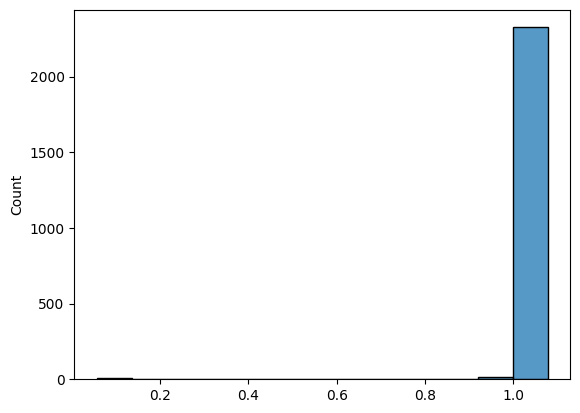

In [50]:
sns.histplot(
    data = [x.mz_coverage/(x.max_mz - x.min_mz) for x in scores.values()]
)

In [53]:
statistics.mean([x.mz_coverage/(x.max_mz - x.min_mz) for x in scores.values()])

1.0692065361309058

In [57]:
coverages = {x.cycle: x.mz_coverage/(x.max_mz - x.min_mz) for x in scores.values()}
sorted(coverages.items(), key=lambda x: x[1], reverse=True)

[(1, 1.0787008119925048),
 (2, 1.0787008119925048),
 (3, 1.0787008119925048),
 (4, 1.0787008119925048),
 (5, 1.0787008119925048),
 (6, 1.0787008119925048),
 (7, 1.0787008119925048),
 (8, 1.0787008119925048),
 (9, 1.0787008119925048),
 (10, 1.0787008119925048),
 (11, 1.0787008119925048),
 (12, 1.0787008119925048),
 (13, 1.0787008119925048),
 (14, 1.0787008119925048),
 (15, 1.0787008119925048),
 (16, 1.0787008119925048),
 (17, 1.0787008119925048),
 (18, 1.0787008119925048),
 (19, 1.0787008119925048),
 (20, 1.0787008119925048),
 (21, 1.0787008119925048),
 (22, 1.0787008119925048),
 (23, 1.0787008119925048),
 (24, 1.0787008119925048),
 (25, 1.0787008119925048),
 (26, 1.0787008119925048),
 (27, 1.0787008119925048),
 (28, 1.0787008119925048),
 (29, 1.0787008119925048),
 (30, 1.0787008119925048),
 (31, 1.0787008119925048),
 (32, 1.0787008119925048),
 (33, 1.0787008119925048),
 (34, 1.0787008119925048),
 (35, 1.0787008119925048),
 (36, 1.0787008119925048),
 (37, 1.0787008119925048),
 (38, 1.07

There is 1 m/z overlap between adjacent windows. This is likely intentional and the method should still be considered as non-overlapping DIA.